# Plasma physics
By Alan Kaptanoglu

This example is based off of the preprint found [here](https://arxiv.org/pdf/2004.10389.pdf)
and builds a data-driven dynamical system model for the temporal POD modes from a plasma simulation.

This notebook shows off some advanced PySINDy features that were useful for this work:
1. Initial guesses to the SINDy optimization object
2. Constrained SR3 and STLSQ algorithms 
    (This is primarily Kathleen Champion's code; see [this preprint](https://arxiv.org/abs/1906.10612))
3. Matrix of thresholds, implemented only for constrained SR3 for now 
    (although constrained SR3 can be used without using constraints and is equivalent to SR3).

## Setup

In [1]:
from matplotlib import pyplot as plt
import numpy as np

import pysindy as ps

In [2]:
# Plotting function for the trajectories we will model. It compares
# the performance of x (the true data), x_train (the fit on the training data)
# and x_sim (the fit on the test data)
cmap = plt.get_cmap("Set1")


def plot_trajectories(x, x_train, x_sim, n_modes=None):
    if n_modes is None:
        n_modes = x_sim.shape[1]

    n_rows = (r + 1) // 2
    kws = dict(alpha=0.7)

    fig, axs = plt.subplots(n_rows, 2, figsize=(12, 2 * n_rows), sharex=True)
    for i, ax in zip(range(n_modes), axs.flatten()):
        ax.plot(time, x[:, i], color="Gray", label="True", **kws)
        ax.plot(t_train, x_train[:, i], color=cmap(1), label="Predicted (train)", **kws)
        ax.plot(t_test, x_sim[:, i], color=cmap(0), label="Predicted (test)", **kws)
        ax.set(title="POD mode {}".format(i + 1))
        ax.legend(bbox_to_anchor=(0, -0.05), ncol=3, loc="upper left")

    for ax in axs.flatten():
        ax.grid(True)
        ax.set(xticklabels=[], yticklabels=[])

    fig.tight_layout()

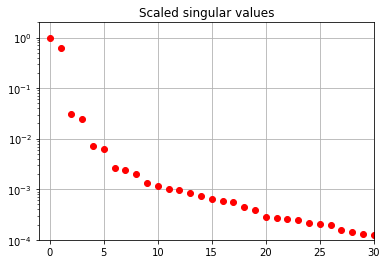

In [3]:
# Load in temporal POD modes of a plasma simulation (trajectories in time)
A = np.loadtxt("data/plasmaphysics_example_trajectories.txt")
time = A[:, 0]

# Load in the corresponding SVD data and plot it
S = np.loadtxt("data/plasmaphysics_example_singularValues.txt")
fig, ax = plt.subplots(1, 1)
ax.semilogy(S / S[0], "ro")
ax.set(title="Scaled singular values", xlim=[-1, 30], ylim=[1e-4, 2])
ax.grid()

## Learning SINDy models for POD mode dynamics


### Unconstrained SR3 algorithm
Let's run a quadratic SINDy model on the first 7 POD modes using the unconstrainted SR3 algorithm with an initial guess.

In [4]:
# My version
r = 7
poly_order = 2
threshold = 0.05
tfrac = 0.8  # Proportion of the data to train on

M = len(time)
M_train = int(len(time) * tfrac)
t_train = time[:M_train]
t_test = time[M_train:]

pod_names = ["a{}".format(i) for i in range(1, r + 1)]

# Normalize the trajectories to the unit ball for simplicity
normalization = sum(np.amax(abs(A), axis=0)[1 : r + 1])
for i in range(1, r + 1):
    A[:, i] = A[:, i] / normalization
    
x = A[:, 1 : r + 1]

# Build an initial guess
initial_guess = np.zeros((r + int(r * (r + 1) / 2), r))
initial_guess[0, 1] = 0.091
initial_guess[1, 0] = -0.091
initial_guess[2, 3] = 0.182
initial_guess[3, 2] = -0.182
initial_guess[5, 4] = -3 * 0.091
initial_guess[4, 5] = 3 * 0.091

# print("Initial guess:")
# print(initial_guess)

x_train = x[:M_train, :]
x0_train = x[0, :]
x_test = x[M_train:, :]
x0_test = x[M_train, :]

In [5]:
# We exclude the constant function from the library
sindy_library = ps.PolynomialLibrary(degree=poly_order, include_bias=False)

# SR3 optimizer with an initial guess
sindy_opt = ps.SR3(
    threshold=threshold, nu=1, initial_guess=initial_guess, max_iter=1000
)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
    feature_names=pod_names,
)

# Fit a model on the training data
model.fit(x_train, t=t_train, unbias=False)
model.print()

a1' = 0.090 a2
a2' = -0.091 a1
a3' = 0.179 a4
a4' = -0.179 a3
a5' = 0.263 a6
a6' = -0.263 a5
a7' = 0.000


In [6]:
# Get Xdot from the measurement data X
x_dot = model.differentiate(x, t=time)

# Predict Xdot on the training and testing data. Since the model was trained on
# Xdot from the training data, x_dot_train is often in excellent agreement with x_dot.
x_dot_train = model.predict(x_train)
x_dot_sim = model.predict(x_test)

print("Model score:", model.score(x, t=time))

Model score: 0.8305711499279242


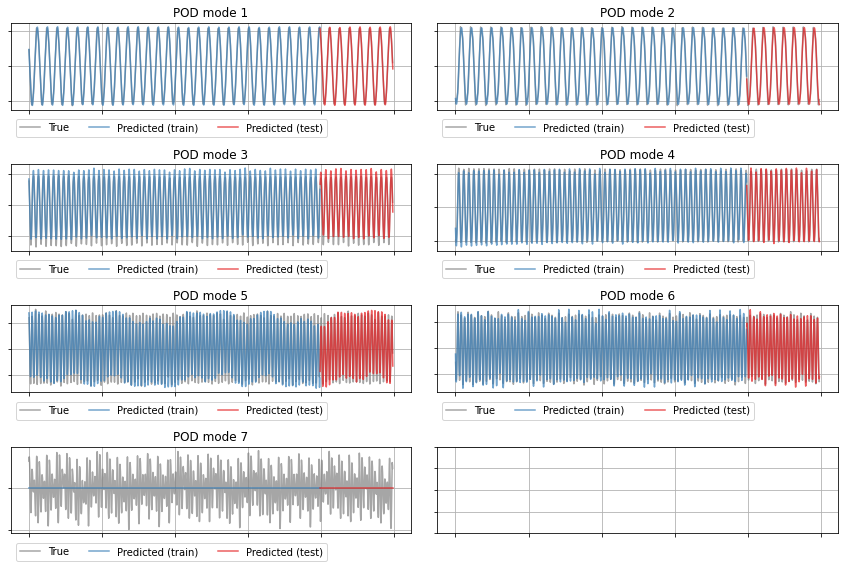

In [7]:
# Plot predicted derivatives
plot_trajectories(x_dot, x_dot_train, x_dot_sim, n_modes=r)

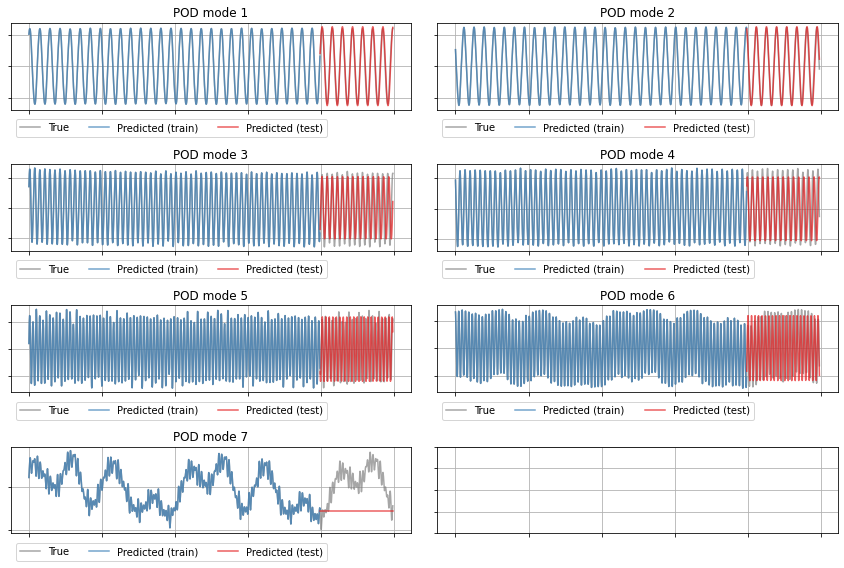

In [8]:
# Forecast the testing data with this identified model
x_sim, output = model.simulate(
    x0_test,
    t_test,
    stop_condition=None,
    full_output=True,
    rtol=1e-20,
    h0=1e-5,
)

# Compare true and simulated trajectories
plot_trajectories(x, x_train, x_sim, n_modes=r)

### Constrained SR3 algorithm
Now let's run a SINDy model on the first 7 modes using the constrainted SR3 algorithm with an initial guess.

Note that this constraint is specific to the magnetohydrodynamics (MHD) model used for the provided simulation data.

In [9]:
threshold = 0.05
constraint_zeros = np.zeros(int(r * (r + 1) / 2))
constraint_matrix = np.zeros((int(r * (r + 1) / 2), int(r * (r ** 2 + 3 * r) / 2)))

# Define the constraint matrix
q = r
for i in range(r):
    constraint_matrix[i, i * (r + 1)] = 1.0
    counter = 1
    for j in range(i + 1, r):
        constraint_matrix[q, i * r + j] = 1.0
        constraint_matrix[q, i * r + j + counter * (r - 1)] = 1.0
        counter += 1
        q += 1

sindy_opt = ps.ConstrainedSR3(
    threshold=threshold,
    nu=1,
    max_iter=10000,
    constraint_lhs=constraint_matrix,
    constraint_rhs=constraint_zeros,
    tol=1e-6,
    initial_guess=initial_guess,
)

In [10]:
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
    feature_names=pod_names,
)

model.fit(x_train, t=t_train, unbias=False)
model.print()

a1' = 0.091 a2
a2' = -0.091 a1
a3' = 0.179 a4
a4' = -0.179 a3
a5' = 0.263 a6
a6' = -0.263 a5
a7' = 0.000


In [11]:
print("Model score:", model.score(x, t=time))

Model score: 0.8305564107959788


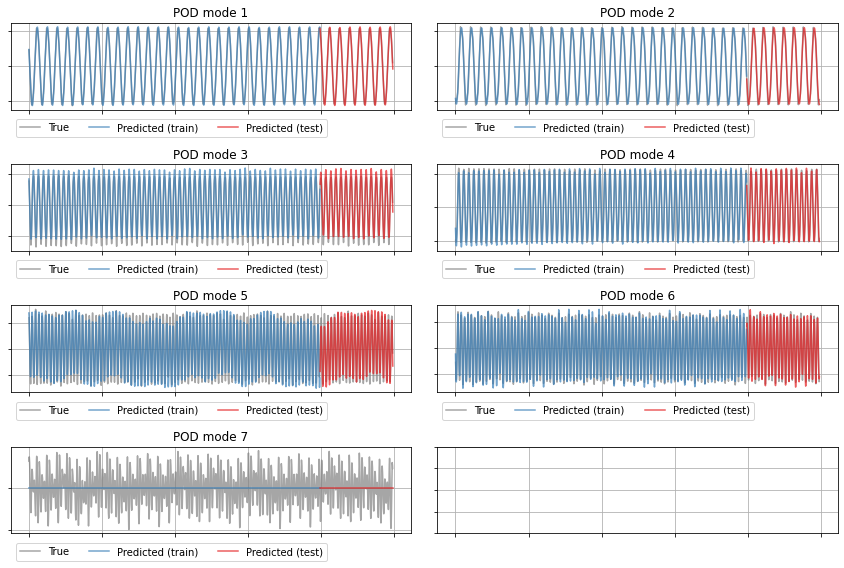

In [12]:
x_dot = model.differentiate(x, t=time)
x_dot_train = model.predict(x_train)
x_dot_sim = model.predict(x_test)

plot_trajectories(x_dot, x_dot_train, x_dot_sim, n_modes=r)

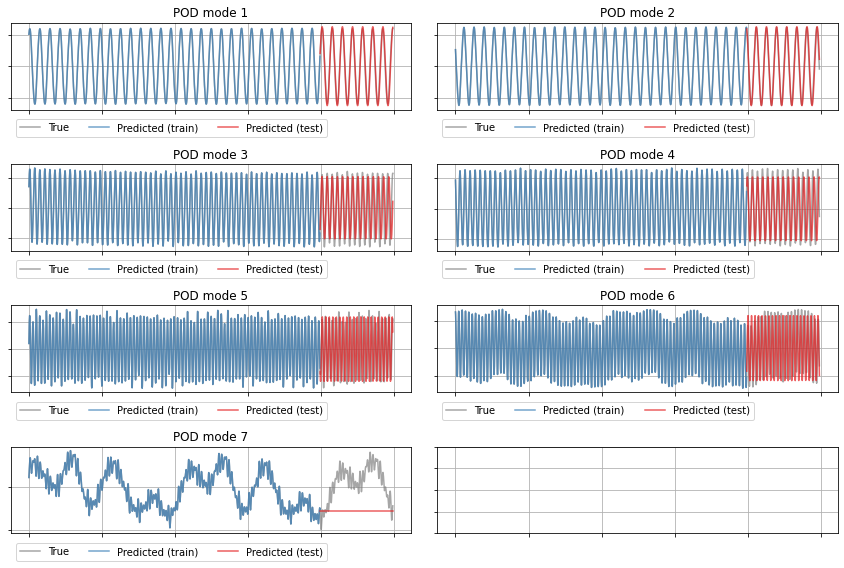

In [13]:
x_sim, output = model.simulate(
    x0_test, t_test, full_output=True, rtol=1e-20, h0=1e-5
)

plot_trajectories(x, x_train, x_sim, r)

### Constrained SR3 algorithm with term-dependent thresholding

Finally, we train a SINDy model on the first 7 modes using constrained SR3 with an initial guess *and* different thresholds for different library terms. We'll test out two sets of thresholds.

#### Encourage linear terms
We'll try get the model to emphasize linear terms by increasing thresholding on the quadratic terms.

In [14]:
threshold = 0.05

# Define a matrix of thresholds
thresholder = "weighted_l0"
thresholds = threshold * np.ones((r + int(r * (r + 1) / 2), r))

# Make the thresholds for the quadratic terms very large
thresholds[r:, :] = 30 * threshold * np.ones(thresholds[r:, :].shape)

sindy_opt = ps.ConstrainedSR3(
    threshold=threshold,
    nu=10,
    max_iter=50000,
    constraint_lhs=constraint_matrix,
    constraint_rhs=constraint_zeros,
    tol=1e-5,
    thresholder=thresholder,
    initial_guess=initial_guess,
    thresholds=thresholds,
)

In [15]:
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
    feature_names=pod_names,
)
model.fit(x_train, t=t_train, unbias=False)
model.print()

a1' = 0.091 a2
a2' = -0.091 a1
a3' = 0.179 a4
a4' = -0.179 a3
a5' = 0.262 a6 + -0.052 a7
a6' = -0.262 a5
a7' = 0.052 a5


In [16]:
x_dot = model.differentiate(x, t=time)
x_dot_train = model.predict(x_train)
x_dot_sim = model.predict(x_test)
print("Model score:", model.score(x, t=time))

Model score: 0.6122175122782466


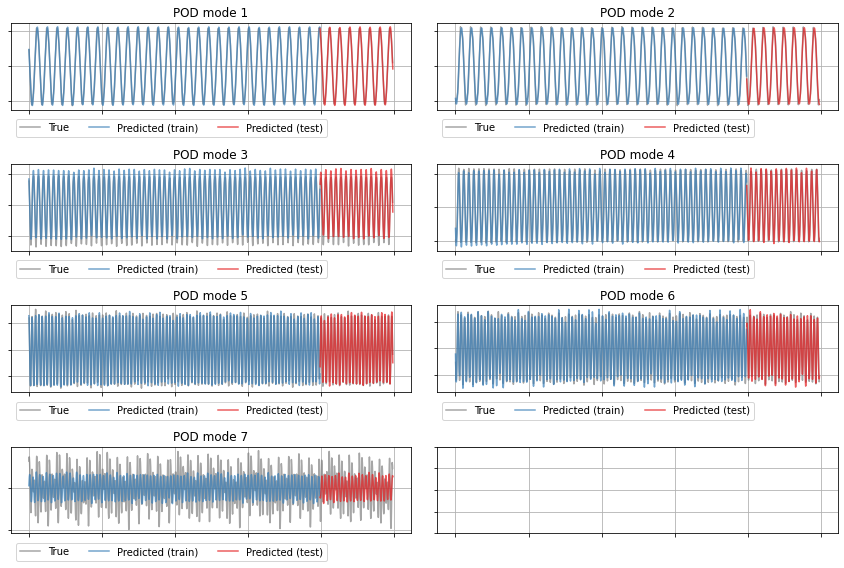

In [17]:
plot_trajectories(x_dot, x_dot_train, x_dot_sim, n_modes=r)

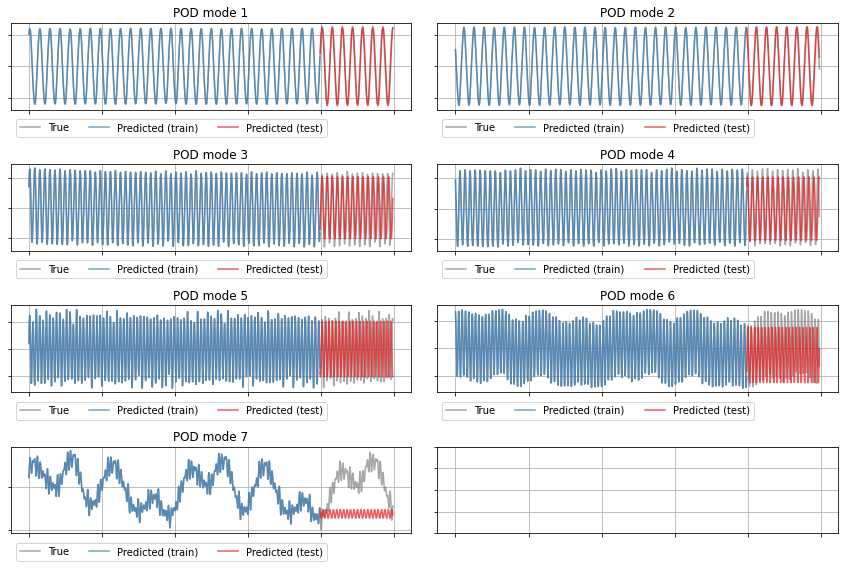

In [18]:
x_sim, output = model.simulate(x0_test, t_test, full_output=True, rtol=1e-20, h0=1e-5)

plot_trajectories(x, x_train, x_sim, n_modes=r)

#### Allow some quadratic terms

The linear terms look pretty good but there are still some small errors in the frequencies
and they can't seem to capture the 7th mode. Let's demand quadratic models for a3-a7. Note that there is a limit
to the progress we can make with this set of modes -- modes 1-6 are close to monochromatic
which will make it difficult to capture frequency dependence beyond the driving frequency
and its harmonics.

In [19]:
threshold = 0.05
thresholder = "weighted_l0"
thresholds = threshold * np.ones((r + int(r * (r + 1) / 2), r))

# Try complicated set of thresholding (try playing around with these)
thresholds[r:, 0:2] = 30 * threshold * np.ones(thresholds[r:, 0:2].shape)
thresholds[r:, 2] = 0.2 * np.ones(thresholds[r:, 2].shape)
thresholds[r:, 3] = 0.05 * np.ones(thresholds[r:, 3].shape)
thresholds[r:, 4:6] = 0.03 * np.ones(thresholds[r:, 4:6].shape)

In [20]:
sindy_opt = ps.ConstrainedSR3(
    threshold=threshold,
    nu=10,
    max_iter=50000,
    constraint_lhs=constraint_matrix,
    constraint_rhs=constraint_zeros,
    tol=1e-5,
    thresholder=thresholder,
    initial_guess=initial_guess,
    thresholds=thresholds,
)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
    feature_names=pod_names,
)

model.fit(x_train, t=t_train, unbias=False)
model.print()

a1' = 0.091 a2
a2' = -0.091 a1
a3' = 0.176 a4
a4' = -0.176 a3 + -0.134 a1 a6 + -0.134 a2 a5 + -0.169 a2 a6 + -0.213 a3 a4
a5' = 0.215 a6 + 0.458 a1 a4 + 0.370 a2 a3 + -0.099 a2 a5 + 0.141 a3 a5 + 0.158 a3 a7 + -0.062 a4 a6
a6' = -0.215 a5 + -0.382 a1 a3 + 0.429 a2 a4 + -0.072 a4 a6 + -0.196 a4 a7
a7' = 0.182 a1 a5 + 0.249 a1 a6 + 0.209 a2 a5 + -0.119 a2 a6 + 0.313 a3^2 + 0.462 a3 a4 + -0.348 a4^2 + 0.133 a4 a6


In [21]:
print("Model score:", model.score(x, t=time))

Model score: 0.9071968741510205


In [22]:
x_dot = model.differentiate(x, t=time)
x_dot_train = model.predict(x_train)
x_dot_sim = model.predict(x_test)

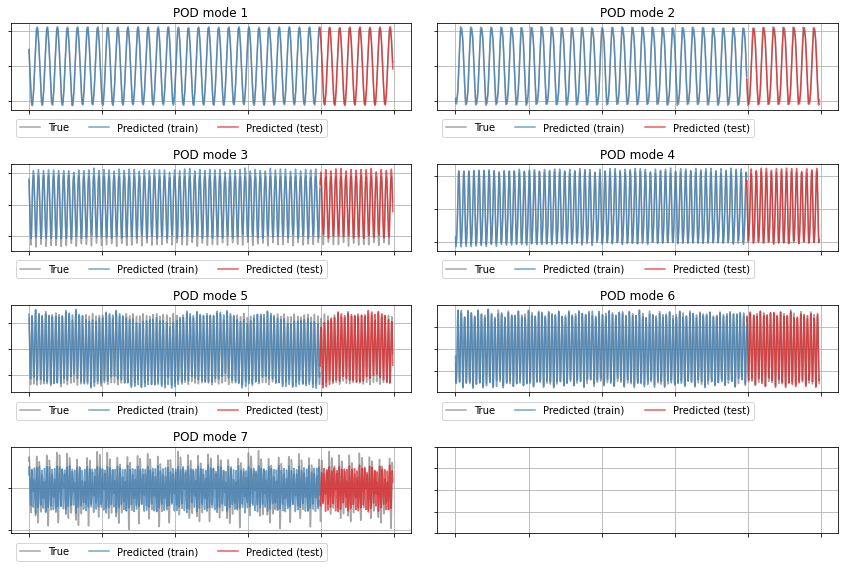

In [23]:
plot_trajectories(x_dot, x_dot_train, x_dot_sim, n_modes=r)

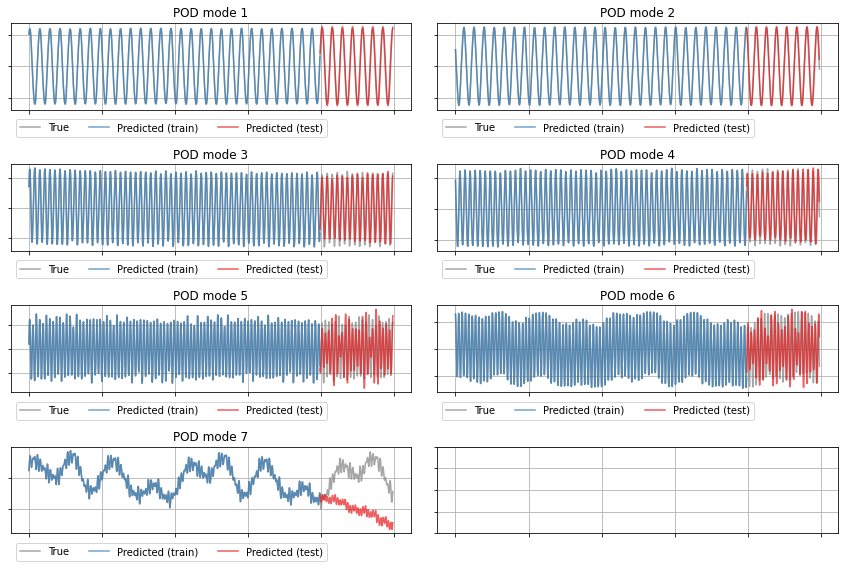

In [24]:
x_sim,output = model.simulate(x0_test,t_test, \
    full_output=True, \
    rtol=1e-20,h0=1e-5)

plot_trajectories(x,x_train,x_sim,r)